<a href="https://colab.research.google.com/github/gabbylancs/ComputerVisionExamples/blob/main/45_90_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
from pathlib import Path
import os
import pandas as pd
import random
from PIL import Image
import torch.optim as optim

**Just checking are data is all there and all gucci x**

/content/drive/MyDrive/types directory exists.
There are 2 directories and 0 images in '/content/drive/MyDrive/types'.
There are 3 directories and 0 images in '/content/drive/MyDrive/types/train'.
There are 0 directories and 1361 images in '/content/drive/MyDrive/types/train/end'.
There are 0 directories and 665 images in '/content/drive/MyDrive/types/train/90'.
There are 0 directories and 1019 images in '/content/drive/MyDrive/types/train/45'.
There are 3 directories and 0 images in '/content/drive/MyDrive/types/test'.
There are 0 directories and 16 images in '/content/drive/MyDrive/types/test/45'.
There are 0 directories and 27 images in '/content/drive/MyDrive/types/test/90'.
There are 0 directories and 31 images in '/content/drive/MyDrive/types/test/end'.
Random image path: /content/drive/MyDrive/types/train/45/a_4_frame_0013 (498).png
Image class: 45
Image height: 200
Image width: 200


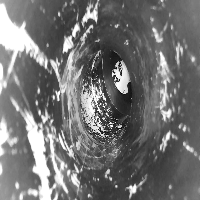

In [ ]:
# Setup path to data folder
data_path = Path("/content/drive/MyDrive/types")
image_path = data_path

if image_path.is_dir():
    print(f"{image_path} directory exists.")

    def walk_through_dir(image_path_path):
      for dirpath, dirnames, filenames in os.walk(image_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

    walk_through_dir(data_path)

    train_dir = image_path / "train"
    test_dir = image_path / "test"

    # Set seed
    random.seed(42)

    image_path_list = list(image_path.glob("*/*/*.png"))
    random_image_path = random.choice(image_path_list)
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)

    # 5. Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.height}")
    print(f"Image width: {img.width}")

else:
    print(f"Did not find {image_path} directory.")
img


**time to decide transform x**

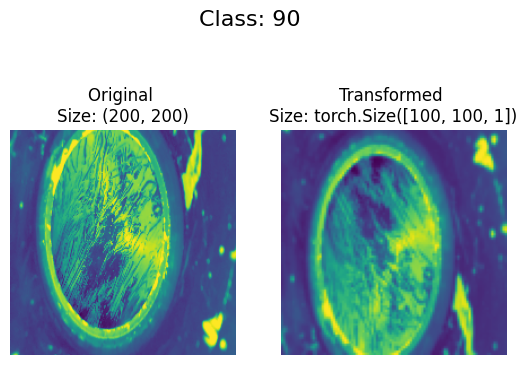

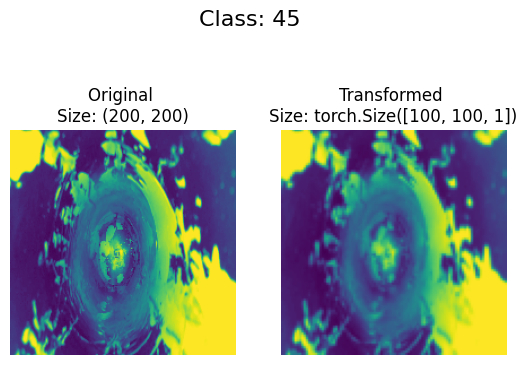

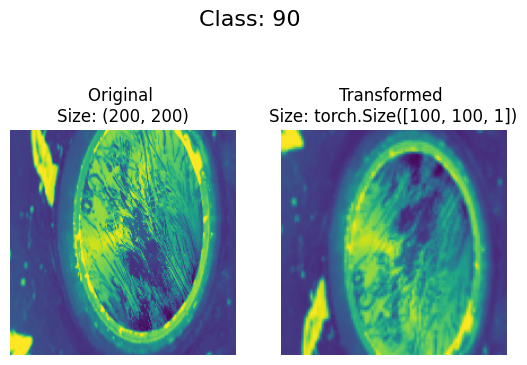

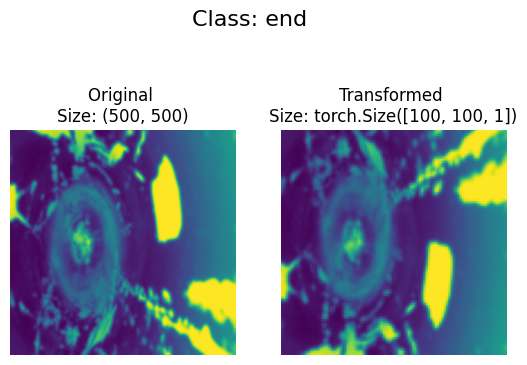

In [ ]:

data_transform = transforms.Compose([
    # Grayscale
    transforms.Grayscale(),
    # Resize
    transforms.Resize((100,100)),
    # Flip the images randomly on the vertical (they're already horizontally flipped)
    transforms.RandomVerticalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

image_paths = [train_dir / "45", train_dir / "90", train_dir / "end"]

def plot_transformed_images(image_paths, transform, n=3, seed=76):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=4)

**dataset creation xxx**

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`  # delete stupid notebook creations x

Train data:
Dataset ImageFolder
    Number of datapoints: 3045
    Root location: /content/drive/MyDrive/types/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 74
    Root location: /content/drive/MyDrive/types/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )


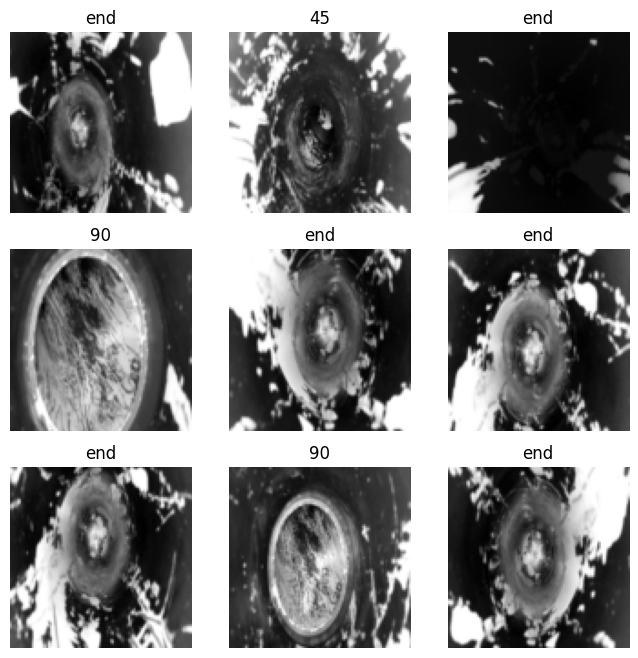

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")


# Prepare loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True, num_workers=0)
num_epochs = 20

labels_map = {
    0: "45",
    1: "90",
    2: "end"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    transformed_image = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(transformed_image.squeeze(), cmap="gray")
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        # Corrected in_channels for conv2 to match previous layer's output (3 channels)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)

        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU(inplace=True)

        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Instantiate a fully connected layer
        # Corrected input size for fc1: 10 (channels) * 24 (height) * 24 (width) = 5760
        self.fc1 = nn.Linear(7203, 60)

        # Instantiate a 2nd fully connected layer
        self.fc2 = nn.Linear(60, 20)

        # Instantiate a 3rd fully connected layer
        self.fc3 = nn.Linear(20, 3)

    def forward(self, x):
        # Apply conv1 followed by relu, then pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Apply conv2 followed by relu, then pool
        #x = self.relu(self.conv2(x))
        #x = self.pool(x)

        # Prepare the image for the fully connected layer (flatten)
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu(self.fc2(x))

        # Apply the final fully connected layer and return the result
        return self.fc3(x)

In [ ]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad()

      # Compute the forward pass
      outputs = net(inputs)

      # Compute the loss function
      loss = criterion(outputs, labels)

      # Compute the gradients
      loss.backward()
      running_loss += loss.item()

      # Update the weights
      optimizer.step()
      print(i)
  epoch_loss = running_loss/len(train_loader.dataset)
  print('Epoch loss:', epoch_loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
Epoch loss: 0.041187986256845284
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143

KeyboardInterrupt: 

In [ ]:
net.eval()
import time
net.eval()
starttime = time.time()
dSQ = 175 # data set quantity
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)
count = 0

for i, data in enumerate(test_loader):
    # Get the image and label from data
    image, label = data

    # Make a forward pass in the net with your image
    output = net(image)

    # Argmax the results of the net
    _, predicted = torch.max(output.data, 1)

    if predicted == label:
        print("Yipes, your net made the right prediction " + str(predicted))
        count = count + 1
    else:
        print("Your net prediction was " + str(predicted) + ", but the correct label is: " + str(label))

    if i > dSQ:
        break

inf = (time.time() - starttime)/dSQ
acc = float(count/dSQ)
print("accuracy: ", acc)

Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([0])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([0])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([0])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([1])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the right prediction tensor([2])
Yipes, your net made the rig

In [ ]:
acc = float(count/74)
print("accuracy: ", acc)

accuracy:  0.9459459459459459


In [ ]:
torch.save(net,"/content/drive/MyDrive/a_1_frames/models/net_juncs")

now load the pipe images

In [ ]:
test_dir_a1 = "/content/drive/MyDrive/a_1_frames/images/images 3"
test_data_a1 = datasets.ImageFolder(root=test_dir_a1,
                                 transform=data_transform)
print(f"Test data:\n{test_data_a1}")
test1_loader = torch.utils.data.DataLoader(test_data_a1, batch_size=1, shuffle=False, num_workers=0)

and see what the results are

In [ ]:
import time
net.eval()
count = 0
starttime = time.time()
for i, data in enumerate(test1_loader):
    try:
        # Get the image and label from data
        image, label = data

        # Make a forward pass in the net with your image
        output = net(image)

        # Argmax the results of the net
        _, predicted = torch.max(output.data, 1)

        print("Count: " + str(i) + " Prediction " + str(predicted))

        if i > 600:
            break
    except OSError as e:
        print(f"Skipping corrupted image at index {i}: {e}")
        continue # Skip to the next image

acc = float(count/126)
print("accuracy: ", acc)
inf = (time.time() - starttime)/340